In [2]:
import os
import glob
import gzip
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
import lxml.etree as ET
import network_io as nio
from itertools import combinations
import random

import re

import random
import numpy as np
import matplotlib.pyplot as plt

import os
import gc
import random
import pandas as pd
import gzip
import xml.etree.ElementTree as ET

from shapely.geometry import Polygon
import alphashape

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
import geopandas as gpd

import pickle
import numpy as np
import random


## 1. Check which combinations we have already computed

This is based on the following assumptions.. first compute dataset_1pm_capacity_reduction_10k (in 'create_subgraphs_1pm_capacity_reduction'), and then compute the speed reductions using this notebook. 
We make sure that the combinations are disjoint.

In [3]:
is_for_1pm = True
result_df_name = 'datasets_created/dataset_1pm_speed_reduction_10k'

# Directory to save the files
output_base_dir = '../../../../data/pop_1pm_simulations/pop_1pm_speed_reduction/networks/'

# Number of files per directory
files_per_dir = 1000

# result_path = '../../../../data/datasets_simulation_outputs/' + result_df_name + '.pt'
string_is_for_1pm = "pop_1pm" if is_for_1pm else "pop_1pct"

base_dir = '../../../../data/' + string_is_for_1pm + '_simulations/' + string_is_for_1pm + '_speed_reduction/'
subdirs_pattern = os.path.join(base_dir, 'output_networks_*')
subdirs = list(set(glob.glob(subdirs_pattern)))
subdirs.sort()

## Create subsets 

In [4]:
# Load the existing dataset
with open('datasets_created/dataset_1pm_cap_reduction_10k.pkl', 'rb') as file:
    existing_dataset = pickle.load(file)

# Convert the existing dataset to a set of sorted tuples for efficient lookup
existing_combinations = set(tuple(sorted(combination)) for combination in existing_dataset)

# List of 20 districts (represented as integers 1 to 20)
districts = list(range(1, 21))

# Function to generate unique subsets that are not in the existing dataset
def generate_unique_subsets(districts, existing_combinations, mean=4, std_dev=3, target_size=50000):
    unique_subsets = set()
    
    while len(unique_subsets) < target_size:
        # Generate a random subset size from a normal distribution, round to the nearest integer
        subset_size = max(1, int(np.random.normal(mean, std_dev)))
        
        # Ensure that subset size does not exceed the number of available districts
        subset_size = min(subset_size, len(districts))
        
        # Randomly sample districts for the subset
        subset = tuple(sorted(random.sample(districts, subset_size)))
        
        # Add the subset to the set of unique subsets only if it's not in the existing dataset
        if subset not in existing_combinations:
            unique_subsets.add(subset)
    
    return list(unique_subsets)

# Generate 10,000 unique subsets that are not in the existing dataset
new_combinations = generate_unique_subsets(districts, existing_combinations, mean=5, std_dev=1, target_size=10000)

# Check the number of unique subsets generated
print(f"Number of new unique subsets generated: {len(new_combinations)}")

Number of new unique subsets generated: 10000


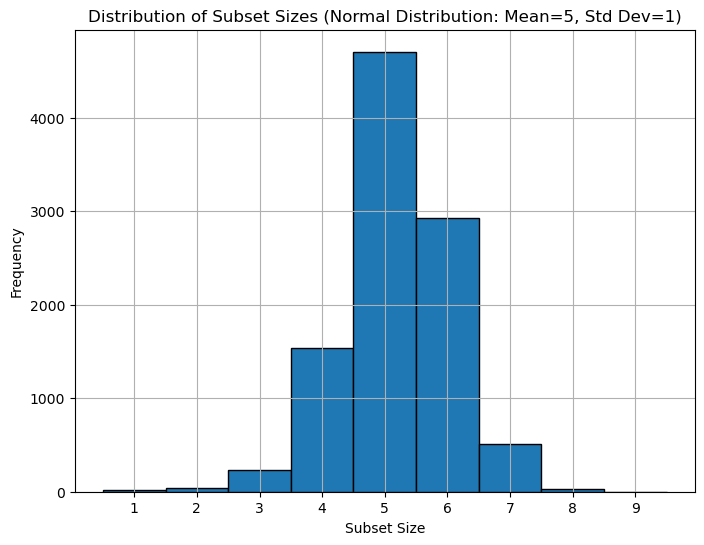

In [5]:
# Extract the sizes of the subsets
subset_sizes = [len(subset) for subset in new_combinations]

# Plot the distribution of subset sizes
plt.figure(figsize=(8, 6))
plt.hist(subset_sizes, bins=range(1, max(subset_sizes)+2), align='left', edgecolor='black')
plt.title('Distribution of Subset Sizes (Normal Distribution: Mean=5, Std Dev=1)')
plt.xlabel('Subset Size')
plt.ylabel('Frequency')
plt.xticks(range(1, max(subset_sizes)+1))
plt.grid(True)
plt.show()

In [6]:
# Convert new_combinations to a set of sorted tuples for comparison
new_combinations_set = set(tuple(sorted(combination)) for combination in new_combinations)

# Find the intersection of the two sets to see how many combinations already exist
common_combinations = new_combinations_set.intersection(existing_combinations)

# Count how many of those combinations are already in the dataset
count_existing = len(common_combinations)

print(f"Number of combinations already in the dataset: {count_existing}")

Number of combinations already in the dataset: 0


Only execute the following code once! 

In [7]:
# Save the random_subset list to a file using pickle
# with open(result_df_name + '.pkl', 'wb') as file:
#     pickle.dump(new_combinations, file)

In [8]:
file_path = '../../../../data/pop_1pm_simulations/pop_1pm/paris_1pm_network.xml.gz'
districts = gpd.read_file("../../../../data/visualisation/districts_paris.geojson")

base_output_links_no_policies = '../../../../data/pop_1pm_simulations/pop_1pm/output_1pm/'
base_network_no_policies = nio.read_network_data(base_output_links_no_policies)
base_network_no_policies.rename(columns={'link': 'id'}, inplace=True)

# Parse nodes and edges
nodes_dict = nio.parse_nodes(file_path)
df_edges = nio.parse_edges(file_path, nodes_dict)
gdf_edges = gpd.GeoDataFrame(df_edges, geometry='geometry', crs='EPSG:2154')
gdf_edges_4326 = gdf_edges.to_crs(epsg=4326)

# Spatial join to find districts overlapping with each edge
gdf_edges_with_districts = gpd.sjoin(gdf_edges_4326, districts, how='left', op='intersects')

# Group by edge and aggregate the district names
gdf_edges_with_districts = gdf_edges_with_districts.groupby('id').agg({
    'from': 'first',
    'to': 'first',
    'length': 'first',
    'freespeed': 'first',
    'capacity': 'first',
    'permlanes': 'first',
    'oneway': 'first',
    'modes': 'first',
    'geometry': 'first',
    'c_ar': lambda x: list(x.dropna())
}).reset_index()

# Rename the aggregated column to 'district'
gdf_edges_with_districts.rename(columns={'c_ar': 'district'}, inplace=True)

# Convert freespeed and capacity to numeric values
gdf_edges_with_districts['freespeed'] = pd.to_numeric(gdf_edges_with_districts['freespeed'], errors='coerce')
gdf_edges_with_districts['capacity'] = pd.to_numeric(gdf_edges_with_districts['capacity'], errors='coerce')

gdf_edges_with_highway = gdf_edges_with_districts.merge(base_network_no_policies[['id', 'osm:way:highway']], on='id', how='left')

gdf_edges_with_highway['cars_allowed'] = gdf_edges_with_highway['modes'].apply(lambda x: 'car' in x)

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/reshape/merge.py:1203: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


In [25]:
# for i, combination in enumerate(new_combinations):
#     if isinstance(combination, int):
#         combination = (combination,)
#     df_copy = gdf_edges_with_highway.copy()
#     df_copy['policy_introduced'] = df_copy['district'].apply(
#         lambda districts: any(d in districts for d in combination)
#     ) & df_copy.apply(
#         lambda row: row['cars_allowed'] is True, axis=1)
#     # Modify freespeed based on the policy_introduced condition
#     df_copy.loc[df_copy['policy_introduced'], 'freespeed'] = np.where(
#         df_copy.loc[df_copy['policy_introduced'], 'freespeed'] > 30/3.6, 
#         30/3.6, 
#         df_copy.loc[df_copy['policy_introduced'], 'freespeed']
#     )
#     print(combination)
#     print("Rows where policy_introduced == True:")
#     print(df_copy[(df_copy['policy_introduced'] == True) & (df_copy['district'].apply(lambda x: 18.0 in x))].head(10))    # print ( " **** ")
#     print("Rows where policy_introduced == False:")
#     print(df_copy[(df_copy['policy_introduced'] == False) & (df_copy['district'].apply(lambda x: 18.0 in x))].head(10))    # print ( " **** ")

#     break

(1, 7, 11, 13, 18, 19)
Rows where policy_introduced == True:
        id        from          to              length  freespeed  capacity  \
23  100676   267486763   267486796   99.79127728388553   4.166667     600.0   
24  100678   267486841   271428246  130.37909053094512   8.333333     600.0   
25  100913  8116443108  8116443106  12.770159805645331   8.333333     480.0   
26  100914  8116443106  8116443103   33.66520516345772   8.333333     480.0   
30  100966   268234194  1343567797   21.48563289186245   8.333333     480.0   
31  100967  1343567797   268234194   21.48563289186245   8.333333     480.0   
32  100968  1343567797  6197561108  127.91216440710275   8.333333     480.0   
33  100969  6197561108  1343567797  127.91216440710275   8.333333     480.0   
34  100970  6197561108   320153255   31.88966246554834   8.333333     480.0   
35  100971   320153255  6197561108   31.88966246554834   8.333333     480.0   

   permlanes oneway                     modes  \
23       1.0      1 

In [ ]:
# # Function to write XML to a compressed .gz file
# def write_xml_to_gz(xml_tree, file_path):
#     with gzip.open(file_path, 'wb') as f:
#         xml_tree.write(f, encoding='utf-8', xml_declaration=True)

# # Ensure the base output directory exists
# os.makedirs(output_base_dir, exist_ok=True)

# # Create and save the networks
# for i, combination in enumerate(new_combinations):
#     if isinstance(combination, int):
#         combination = (combination,)
#     df_copy = gdf_edges_with_highway.copy()
#     df_copy['policy_introduced'] = df_copy['district'].apply(
#         lambda districts: any(d in districts for d in combination)
#     ) & df_copy.apply(
#         lambda row: row['cars_allowed'] is True, axis=1)
#     # Modify freespeed based on the policy_introduced condition
#     df_copy.loc[df_copy['policy_introduced'], 'freespeed'] = np.where(
#         df_copy.loc[df_copy['policy_introduced'], 'freespeed'] > 30/3.6, 
#         30/3.6, 
#         df_copy.loc[df_copy['policy_introduced'], 'freespeed']
#     )
#     # Determine the subdirectory based on the file index
#     dir_index = (i // files_per_dir) + 1
#     subdir_name = f"networks_{dir_index * files_per_dir}"
#     output_dir = os.path.join(output_base_dir, subdir_name)
    
#     # Create the subdirectory if it doesn't exist
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Determine the filename based on the combination
#     if len(combination) == 1:
#         filename = f"network_d_{combination[0]}.xml.gz"
#     else:
#         filename = f"network_d_{'_'.join(map(str, combination))}.xml.gz"
    
#     # Convert the DataFrame to XML
#     xml_tree = nio.dataframe_to_xml(df_copy, nodes_dict)
    
#     # Write the XML to a compressed .gz file
#     file_path = os.path.join(output_dir, filename)
#     nio.write_xml_to_gz(xml_tree, file_path)

#     # Clear the dataframe from memory
#     del df_copy
#     gc.collect()

# # Example: Display the file paths of the saved files
# output_files = [os.path.join(root, f) for root, _, files in os.walk(output_base_dir) for f in files]
# print(output_files)

['../../../../data/pop_1pm_simulations/pop_1pm_speed_reduction/networks/networks_5000/network_d_3_4_7_15_19.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_speed_reduction/networks/networks_5000/network_d_4_6_9_13_19.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_speed_reduction/networks/networks_5000/network_d_1_4_7_10_11_15.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_speed_reduction/networks/networks_5000/network_d_2_4_13_16_17_19.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_speed_reduction/networks/networks_5000/network_d_7_11_14_15_18_19.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_speed_reduction/networks/networks_5000/network_d_1_4_13_20.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_speed_reduction/networks/networks_5000/network_d_2_5_6_10_11_13.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_speed_reduction/networks/networks_5000/network_d_2_5_10_11_14_16_20.xml.gz', '../../../../data/pop_1pm_simulations/pop_1pm_speed